In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default, horiz_merge
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100

def show(df):
    for j in df.index:
        print(j)
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
        X = grid_of_images_default(X)
        imsave('out.png', X)
        im = Image('out.png')
        display(im)
db = load_db()

In [31]:
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
    for k, v in j['stats'].items():
        col[k] = v
    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    

    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    #col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    #col['digits_object'] = 1 - col['digits_entropy']
    #col['letters_object'] = 1 - col['letters_entropy']
    #col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    #col['emnist_object'] = 1 - col['emnist_letters_entropy']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')
df_full.to_csv('hypers.csv')

## Fix stride. vary nb of layers

In [29]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==2]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_objectness,nb_layers,nb_params,noise,ratio_unique,recons,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9e80faae4fb4ae36b2766648824eac09,128.0,0.116791,12.550046,0.086,0.800376,0.191304,6.500855e+07,0.078,0.002076,4.151053,0.018,0.013,0.757,0.352276,0.141,5.123708,NaN,0.522073,0.082004,14.290085,0.848,0.810578,0.347885,1.427359e+08,0.501,0.002082,5.316375,1,6529.0,NaN,0.967,0.0003,mnist_deep,2.0,NaN
68adffea6c98fedf329644122d56fa36,128.0,0.039539,19.538910,0.577,0.911845,0.087772,6.482822e+07,0.517,0.002000,6.700230,0.090,0.080,0.568,0.248701,0.173,13.314023,NaN,0.788424,0.112240,57.670715,0.365,0.926126,0.116562,1.426116e+08,0.316,0.002006,14.033784,2,825985.0,NaN,1.000,0.4166,mnist_deep,2.0,NaN
901dad8ec11f23191d86fa6279d47c65,128.0,0.031575,15.541529,0.707,0.915356,0.084485,6.481787e+07,0.656,0.002000,6.845440,0.108,0.096,0.482,0.246643,0.154,12.352144,NaN,0.765771,0.100727,52.514980,0.250,0.927061,0.110468,1.426481e+08,0.213,0.002006,14.415942,3,1645441.0,NaN,1.000,0.1821,mnist_deep,2.0,NaN
63c1be88f742117d115d076216ac85d1,128.0,0.020904,10.919588,0.849,0.916866,0.055326,6.480193e+07,0.794,0.002000,7.269512,0.130,0.121,0.440,0.208254,0.196,10.687059,NaN,0.676443,0.095547,33.215351,0.124,0.778797,0.088160,1.426905e+08,0.113,0.002006,9.548794,4,2464897.0,NaN,1.000,0.1293,mnist_deep,2.0,NaN
581582abec259852f4a01f7e79ed97db,128.0,0.020118,7.382170,0.964,0.851105,0.056269,6.483472e+07,0.886,0.002008,6.220617,0.128,0.122,0.458,0.212822,0.178,8.264774,NaN,0.614825,0.109743,22.542377,0.024,0.767487,0.096898,1.427642e+08,0.021,0.002014,9.044111,5,3284353.0,NaN,0.996,0.0318,mnist_deep,2.0,NaN
8ecaf99d22cf4cb469912b9fae25aac2,128.0,0.008583,4.169066,0.998,0.630844,0.042352,6.493132e+07,0.967,0.005644,3.949130,0.098,0.093,0.331,0.196629,0.108,5.691341,NaN,0.426911,0.099368,8.652865,0.001,0.602850,0.086963,1.428706e+08,0.001,0.005650,5.471218,6,4103809.0,NaN,0.593,0.0097,mnist_deep,2.0,NaN


In [ ]:
show(df)

## Fix nb layers. Vary stride

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

In [ ]:
show(df)

# wta lifetime sparsity

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_lifetime']
df = df[df['zero_ratio']==0.7]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## wta kchannel

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df = df[df['noise'] < 0.6]
show(df)

In [ ]:
df.plot('noise', ['digits_count'])

In [ ]:
from IPython.display import Image
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

In [4]:
x = df_full[['nb_layers', 'bottleneck', 'stride', 'zero_ratio', 'noise']].fillna(-1)
y = df_full['recons'].fillna(0.0)

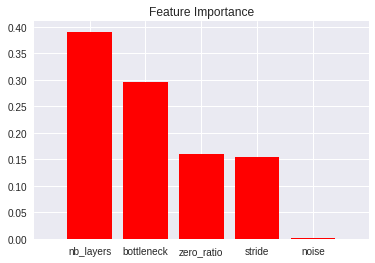

In [11]:
from scikitplot.estimators import plot_feature_importances
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg = GradientBoostingRegressor(n_estimators=30, max_depth=20)
reg.fit(x, y)
#reg.feature_importances_ = reg.coef_
plot_feature_importances(reg, feature_names=x.columns)

In [16]:
pd.DataFrame({'delta': np.abs(reg.predict(x)-y), 'y': y}).sample(10)

,delta,y
job_id,,
78d155d20b40759f2f5ac333aee1c616,0.004161,0.0040
ab45d34bd45790c492f913e11f28b1dd,0.000786,0.0836
9a6da4b02514b0828331badb37217bb7,0.004101,0.0054
7d308b4f1c92e8eb6ef26e03c8540032,0.006793,0.2624
fcfe73728bc4338ad48a0487eca9bd9c,0.010223,0.3433
67bf47b5fd9034643709629bde89041c,0.003650,0.0085
8ed4c929db06fb50bbe9c6723f153772,0.003601,0.0098
e611fba0dfcce6b264cfec8a32e6b5be,0.004025,0.0046
bd37901de050618165cd83355b7df1b4,0.003747,0.0129


In [ ]:
df_full.plot('emnist_letters_count', 'emnist_objectness', kind='scatter')

In [ ]:
d = df_full.copy()
#d['y'] = d['emnist_letters_count']
d['y'] =  d['emnist_letters_count'] + 5*d['emnist_object'] + 10*d['letters_diversity']
#d['y'] =  30*d['emnist_digits_count'] + d['emnist_objectness']
#d['y'] = d['letters_objectness']
d = d.sort_values(by='y', ascending=False)
show(d.iloc[0:10])

In [19]:
labels = [
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'recons',
    'ratio_unique'
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,recons,ratio_unique
digits_count,1,-0.897334,0.504346,0.410802,0.0418502,0.47685,-0.00953573,0.252758
letters_count,-0.897334,1,-0.420536,-0.322768,0.0374954,-0.395098,0.0460488,-0.156755
digits_objectness,0.504346,-0.420536,1,0.921371,0.716197,0.956652,0.195174,0.903427
letters_objectness,0.410802,-0.322768,0.921371,1,0.832285,0.957296,0.389438,0.872042
digits_and_letters_objectness,0.0418502,0.0374954,0.716197,0.832285,1,0.74305,0.32728,0.830626
emnist_objectness,0.47685,-0.395098,0.956652,0.957296,0.74305,1,0.304504,0.866904
recons,-0.00953573,0.0460488,0.195174,0.389438,0.32728,0.304504,1,0.245437
ratio_unique,0.252758,-0.156755,0.903427,0.872042,0.830626,0.866904,0.245437,1


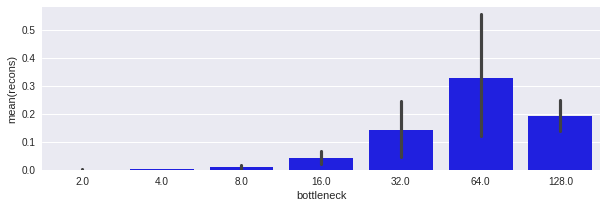

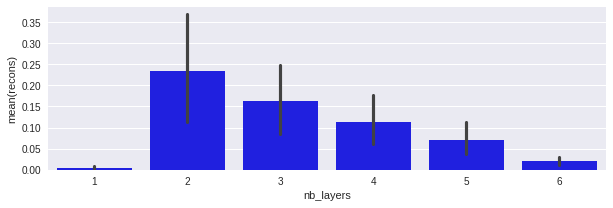

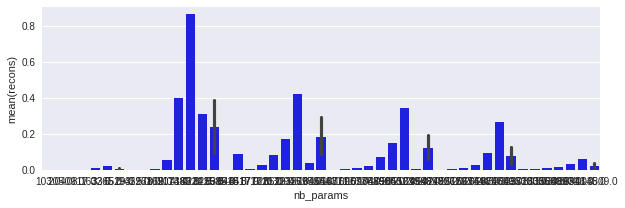

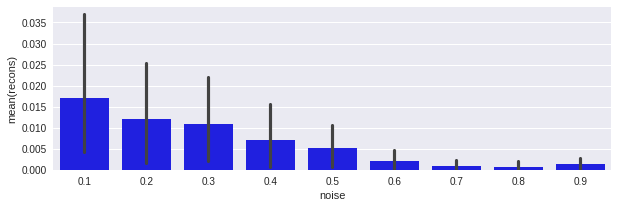

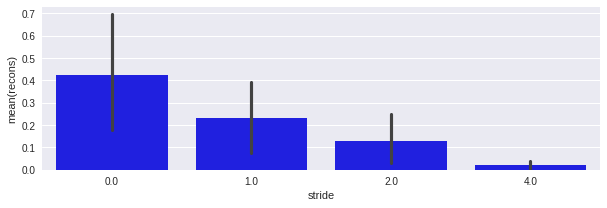

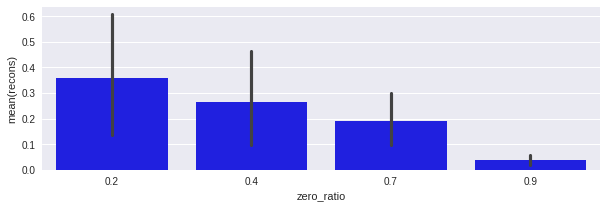

In [27]:
d = df_full
#d = df_full.fillna(-1)
#d = d[d['sampler']  == 'mnist_capacity']
ycols = ['recons']
xcols = ['bottleneck', 'nb_layers', 'nb_params', 'noise', 'stride', 'zero_ratio']
for xcol in xcols:
    for ycol in ycols:
        fig = plt.figure(figsize=(10, 3))
        sns.barplot(x=xcol, y=ycol, data=d, color='blue')
        plt.show()

In [33]:
d = df_full
d = d[d['nb_layers'] == 3]
d = d.sort_values(by='recons', ascending=False)
d.iloc[0:20]

,bottleneck,digits_and_letters_entropy,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_objectness,nb_layers,nb_params,noise,ratio_unique,recons,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5511413bb44248b61f32518f638a8d9e,128.0,0.043103,15.068205,0.712,9.121210e-01,0.109552,6.482374e+07,0.621,0.002000,6.414445,0.031,0.029,0.694,0.310742,0.131,8.729666,NaN,6.468626e-01,0.100108,26.331829,0.231,9.171454e-01,0.121261,1.426300e+08,0.193,0.002006,13.536750,3,1645441.0,NaN,1.000,0.7190,mnist_deep,0.0,NaN
f316dedd30ebc5f51c4678f07979436c,128.0,0.031410,14.714568,0.773,9.241394e-01,0.083757,6.478472e+07,0.713,0.002000,6.948976,0.081,0.073,0.572,0.254680,0.178,12.290185,NaN,7.754346e-01,0.104893,55.180447,0.172,9.265543e-01,0.101766,1.426092e+08,0.153,0.002006,14.877086,3,1645441.0,NaN,1.000,0.6635,mnist_deep,1.0,NaN
6200e894f920a6659d48adcb799e1bee,128.0,0.110627,7.355932,0.131,7.229702e-01,0.265471,6.500076e+07,0.115,0.042311,3.124804,0.019,0.016,0.762,0.283204,0.083,3.137175,NaN,3.890528e-01,0.069677,7.466353,0.841,6.205130e-01,0.169838,1.427632e+08,0.493,0.042317,5.077163,3,1645441.0,NaN,0.651,0.4946,mnist_deep_lifetime,NaN,0.2
cc68a4a318fc51e325ec4b74e1563812,128.0,0.039947,19.870729,0.550,9.282532e-01,0.089378,6.480360e+07,0.503,0.002000,6.912533,0.067,0.060,0.500,0.281559,0.132,11.834738,NaN,7.692078e-01,0.120771,49.336044,0.398,8.919794e-01,0.101825,1.425943e+08,0.322,0.002006,13.323232,3,1645441.0,NaN,1.000,0.4765,mnist_deep_kchannel,NaN,0.7
7e7632c0f86786bda97931c4e88bbfd7,64.0,0.031813,10.997512,0.884,9.226163e-01,0.079285,6.480698e+07,0.789,0.002000,7.017381,0.059,0.054,0.582,0.268081,0.143,11.069925,NaN,7.797051e-01,0.121033,51.646221,0.076,9.350982e-01,0.112106,1.426599e+08,0.069,0.002006,14.681621,3,1235777.0,NaN,1.000,0.4221,mnist_capacity,NaN,NaN
a694652e326a2946f411a8c9113dfe9d,128.0,0.206683,1.140117,0.009,6.989747e-02,0.297056,6.519457e+07,0.009,0.940360,1.077189,0.000,0.000,0.988,0.405852,0.000,1.071705,NaN,1.282851e-02,0.068940,1.061070,0.990,5.300543e-02,0.528814,1.430567e+08,0.003,0.940366,1.120408,3,1645441.0,NaN,0.006,0.2719,mnist_deep_lifetime,NaN,0.4
901dad8ec11f23191d86fa6279d47c65,128.0,0.031575,15.541529,0.707,9.153564e-01,0.084485,6.481787e+07,0.656,0.002000,6.845440,0.108,0.096,0.482,0.246643,0.154,12.352144,NaN,7.657710e-01,0.100727,52.514980,0.250,9.270615e-01,0.110468,1.426481e+08,0.213,0.002006,14.415942,3,1645441.0,NaN,1.000,0.1821,mnist_deep,2.0,NaN
b75919e611b9c6ed0f063749d17ad699,32.0,0.033376,11.621178,0.869,9.256088e-01,0.079668,6.482478e+07,0.770,0.002000,7.027142,0.084,0.074,0.454,0.279138,0.132,11.713885,NaN,7.796417e-01,0.130803,50.456188,0.099,9.233820e-01,0.107689,1.427004e+08,0.086,0.002006,14.359535,3,1030945.0,NaN,1.000,0.1704,mnist_capacity,NaN,NaN
22f21be8ae12aba3457e2469d290dd52,128.0,0.639410,0.999999,0.000,-4.342945e-11,0.397720,NaN,0.000,1.001000,0.999993,0.000,0.000,0.000,0.883035,0.000,1.000001,NaN,-1.712995e-11,0.859961,0.999999,0.000,-3.069277e-11,0.805414,NaN,0.000,1.001006,1.000004,3,1645441.0,NaN,0.001,0.1455,mnist_deep_lifetime,NaN,0.7
